# Artificial Neural Networks and Deep Learning - Homework 2


## 🌐 Connect Colab to Google Drive

In [1]:
#from google.colab import drive

#drive.mount("/gdrive")
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2024-12-07 01:03:52.531361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 01:03:52.598525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 01:03:52.616240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 01:03:52.665324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 01:03:56.212509: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Keras version: 3.4.1
GPU devices: 1


I0000 00:00:1733529842.708329  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733529842.814735  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733529842.816627  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# Set the mixed precision policy to use float16 (half precision)
policy = tfk.mixed_precision.Policy('mixed_float16')
tfk.mixed_precision.set_global_policy(policy)

## ⏳ Load and prepare the Data

In [4]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [6]:
# Remove outliers (containing aliens)
outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [7]:
# Count the number of pixels with a given label
label_list, counts = np.unique(y_train, return_counts=True)
for label, count in zip(label_list, counts):
    print(f"Number of pixels with label {int(label)}: {count}")

Number of pixels with label 0: 4988826
Number of pixels with label 1: 6957538
Number of pixels with label 2: 4776810
Number of pixels with label 3: 3770823
Number of pixels with label 4: 26963


In [8]:
# Count the number of images containing a pixel with a given label
counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        counts[int(value)] += 1
for label, count in enumerate(counts):
    print(f"Number of images containing label {int(label)}: {count}")

Number of images containing label 0: 2087
Number of images containing label 1: 1281
Number of images containing label 2: 1160
Number of images containing label 3: 863
Number of images containing label 4: 63


In [9]:
# Since there are few images with label 4, stratify using the presence of label 4
stratify=[]
for labels in y_train:
    label_list = np.unique(labels)
    if 4.0 in label_list:
        stratify.append(1)
    else:
        stratify.append(0)
stratify = np.array(stratify)

In [ ]:
# Split into training and validation (80-20)
val_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=val_size, stratify=stratify
)

In [11]:
# Check imbalance between training and validation
train_counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        train_counts[int(value)] += 1

val_counts = [0 for _ in range(num_classes)]
for labels in y_val:
    label_list = np.unique(labels)
    for value in label_list:
        val_counts[int(value)] += 1

ratios = [val_counts[i] / train_counts[i] / val_size for i in range(num_classes)]

for i in range(num_classes):
    print(f"Ratio of images containing a label in validation vs train compared to ideal split for label {i}: {ratios[i]}")

Ratio of images containing a label in validation vs train compared to ideal split for label 0: 1.2150089338892196
Ratio of images containing a label in validation vs train compared to ideal split for label 1: 1.3667992047713717
Ratio of images containing a label in validation vs train compared to ideal split for label 2: 1.1246040126715944
Ratio of images containing a label in validation vs train compared to ideal split for label 3: 1.2718023255813953
Ratio of images containing a label in validation vs train compared to ideal split for label 4: 0.625


In [12]:
category_map = {
    0: 0,  # background
    1: 1,  # soil
    2: 2,  # bedrock
    3: 3,  # sand
    4: 4,  # big rock
}


def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [13]:
@tf.function
def random_flip_h(image, label):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label

@tf.function
def random_flip_v(image, label):
    """Consistent random vertical flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(label), lambda: label
    )
    return image, label

@tf.function
def random_brightness(image):
    delta = tf.random.uniform([])
    delta_thresh = 0.1
    image = tf.cond(
        delta < 3*delta_thresh, lambda: tf.image.adjust_brightness(image, delta=delta), lambda: image
    )
    return image

@tf.function
def random_contrast(image):
    factor = tf.random.uniform([])
    factor_thresh = 2
    image = tf.cond(
        factor < factor_thresh/6, lambda: tf.image.adjust_contrast(image, contrast_factor=factor), lambda: image
    )
    return image

@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label)
    #image, label = random_flip_v(image, label)
    #image = random_brightness(image)
    #image = random_contrast(image)
    return image, label

In [14]:
def add_intermediate(image, label):
    # Downsample label for intermediate outputs
    intermediate_label = tf.image.resize(label, [label.shape[0] // 2, label.shape[1] // 2], method="bilinear")
    
    # Return a dictionary of labels for multiple outputs
    return image, {
        "output_layer": label,              # Final output label
        "intermediate_output": intermediate_label,  # Intermediate output label
    }

In [15]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentations
    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    
    # Add intermediate labels
    dataset = dataset.map(add_intermediate)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
batch_size = 32

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels_dict in train_dataset.take(1):
    labels = labels_dict["output_layer"]
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...


I0000 00:00:1733529851.878443  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733529851.880579  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733529851.882494  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733529852.136571  638214 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


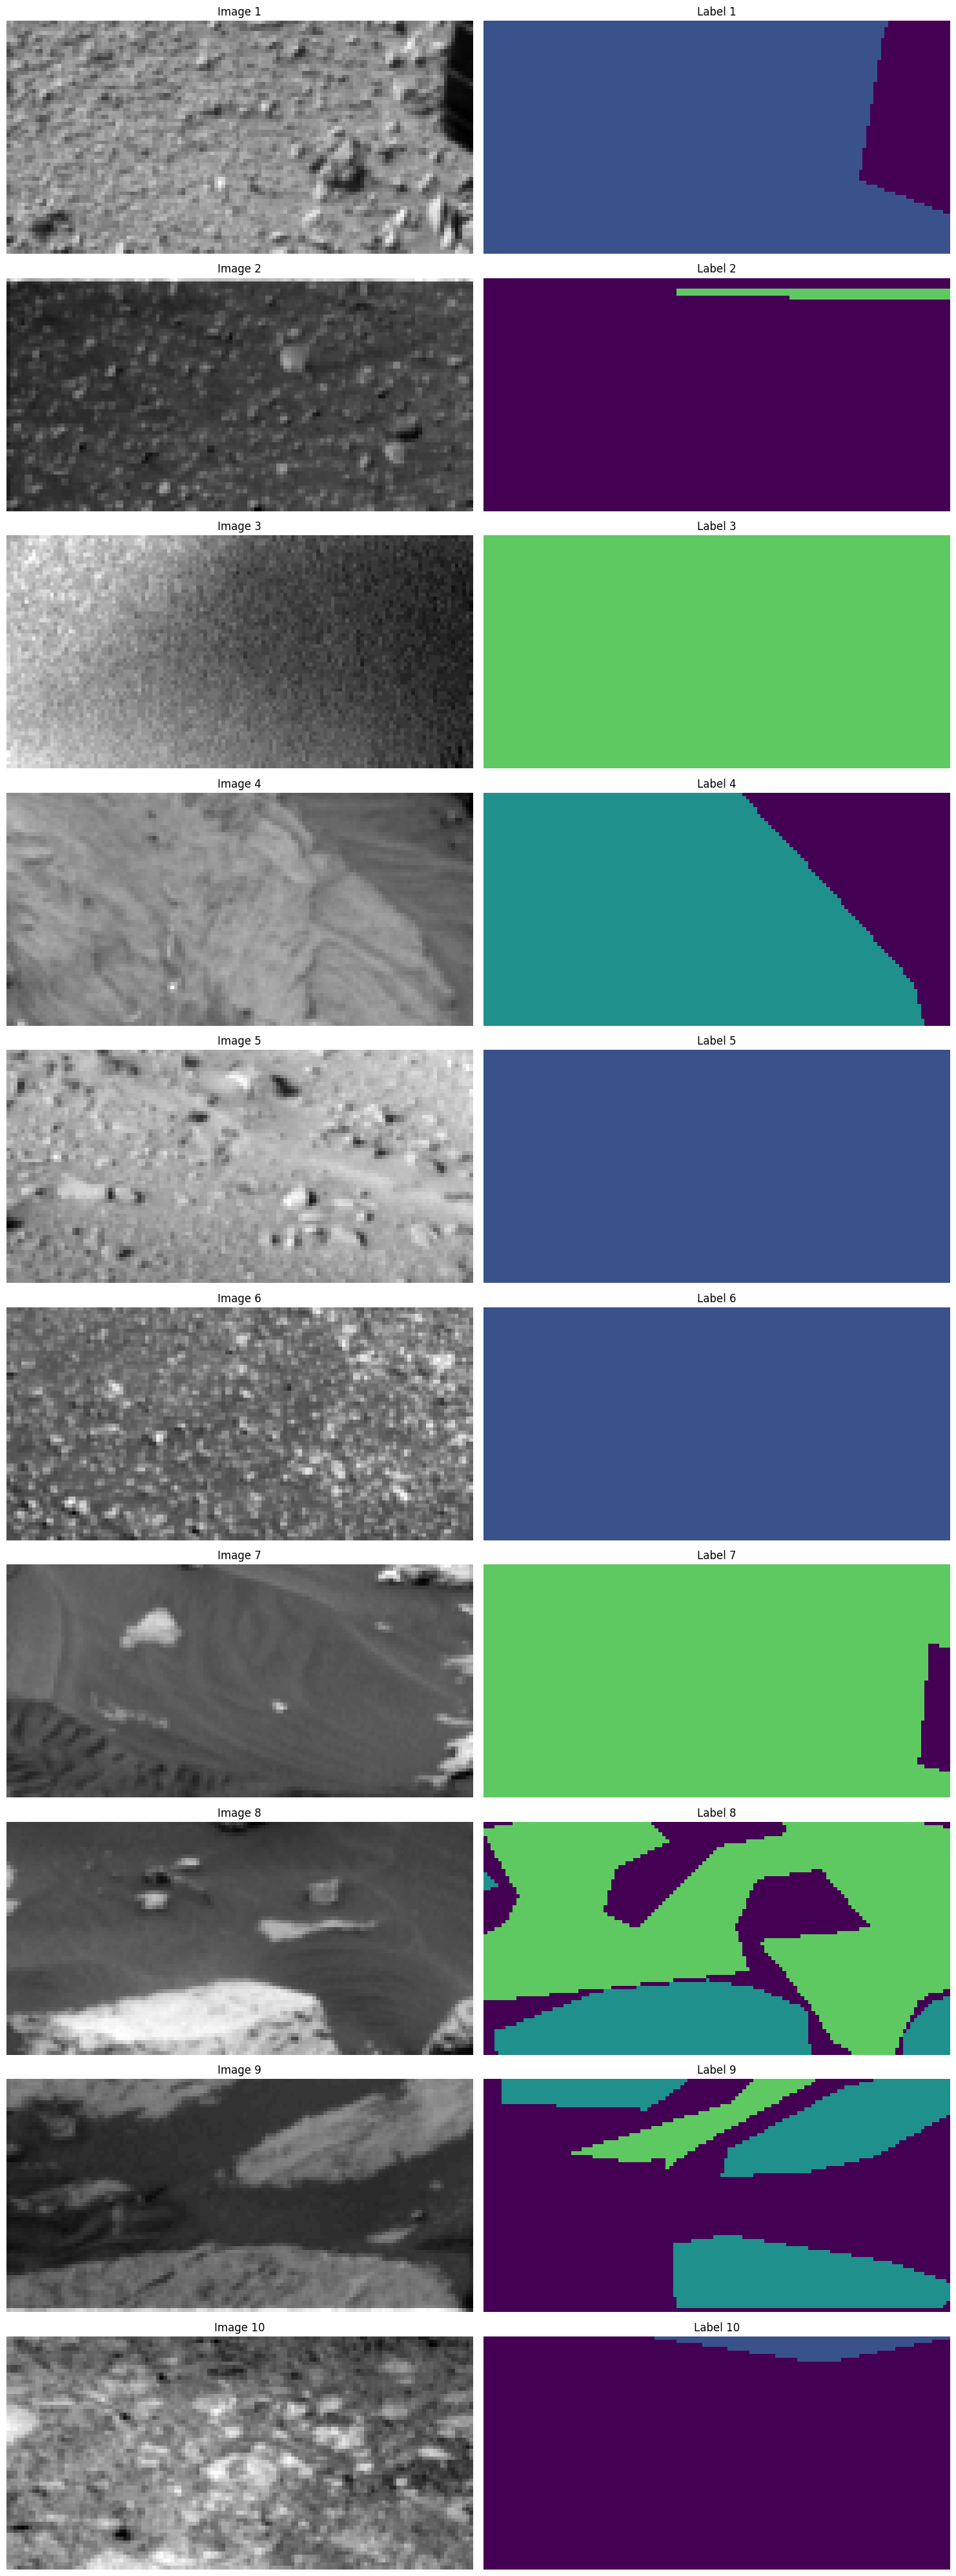

In [17]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="grey")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

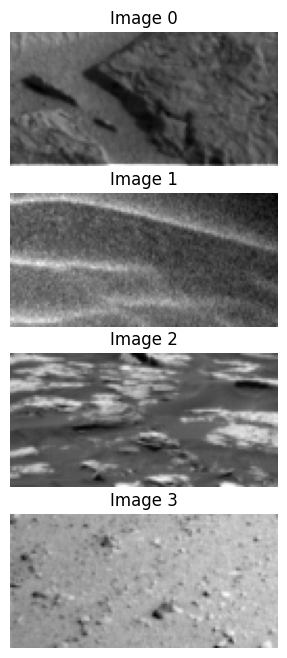

In [18]:
# Visualize examples from the test set.
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="grey")
    plt.title(f"Image {j}")
    plt.axis("off")

## 🛠️ Define the model

In [19]:
def unet_block(
    input_tensor, filters, kernel_size=3, activation="relu", stack=2, name=""
):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding="same",
            name=name + "conv" + str(i + 1),
        )(x)
        x = tfkl.BatchNormalization(name=name + "bn" + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + "activation" + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [20]:
# Define a Residual block with configurable parameters (currently unused, but
# used in older models). Note that a modified version of this block is used in
# the final model, by combining it with the inception block.
def residual_unet_block(x, filters, kernel_size=3, padding='same',
                        downsample=False, activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # First convolutional block with Batch Normalisation and activation.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [21]:
# Define the Inception block with batch normalization (BN) and with multiple
# convolution paths and optional downsampling.
def inception_block_bn(x, filters, padding='same',
                       downsample=False, activation='relu', stack=2, name='inception'):
    # This inception block consists of a 1x1 convolution path, a 3x3 convolution
    # path, a 5x5 convolution path, and a pooling path. The paths are then
    # concatenated to form the final block output.
    # The reason for using multiple paths is to allow the model to learn
    # different features at different scales, and to increase the model's
    # capacity without increasing the number of parameters too much.
    # The downsampling (pooling) is not mandatory.

    # Loop through specified stack layers for multiple inception paths.
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation.
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer.
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer.
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction.
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output.
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [22]:
# Define the a residual block using an inception block instead of the
# convolutional path. This mixed block is used in the final model, and it
# combines the benefits of both residual and inception blocks. We believe
# that the residual and inception blocks are complementary, as their guesses
# don't seem to perfectly overlap. See the report for more details.
def inception_residual_unet(x, filters, padding='same', downsample=False,
                            activation='relu', stack=4, inception_stack=1,
                            name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # Create the inception block.
        x = inception_block_bn(x, filters, padding, downsample=False, activation=activation,
                               stack=inception_stack, name=f'{name}_inception_{s}')

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [23]:
def attention_gate(input_tensor, gating_tensor, inter_channels):
    # 1x1 convolution on the input (skip connection)
    theta_x = tfkl.Conv2D(inter_channels, kernel_size=1, strides=2, padding='same')(input_tensor)
    # 1x1 convolution on the gating (decoder output)
    phi_g = tfkl.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(gating_tensor)
    # Add and apply ReLU
    add = tfkl.Add()([theta_x, phi_g])
    relu = tfkl.Activation('relu')(add)
    # Generate attention weights
    psi = tfkl.Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu)
    # Upsample attention weights to match input_tensor spatial dimensions
    upsampled_psi = tfkl.UpSampling2D()(psi)
    # Multiply input tensor by attention weights
    output = tfkl.Multiply()([input_tensor, upsampled_psi])
    return output

In [24]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Downsampling path
    down_block_1 = inception_residual_unet(input_layer, 96, name="down_block1_")
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = inception_residual_unet(d1, 192, name="down_block2_")
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = inception_residual_unet(d2, 384, name="bottleneck")

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    attention_1 = attention_gate(down_block_2, bottleneck, 192)
    u1 = tfkl.Concatenate()([u1, attention_1])
    u1 = inception_residual_unet(u1, 192, name="up_block1_")

    intermediate_output = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="intermediate_output",
    )(u1)

    u2 = tfkl.UpSampling2D()(u1)
    attention_2 = attention_gate(down_block_1, u1, 96)
    u2 = tfkl.Concatenate()([u2, attention_2])
    u2 = inception_residual_unet(u2, 96, name="up_block2_")

    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="output_layer",
    )(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=[output_layer,intermediate_output], name="UNet")
    return model

In [25]:
# Define parameters
epochs = 1000
learning_rate = 1e-4

In [26]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
try:
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)
except:
    print("Model too complex to plot!")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        24 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        16 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        32 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Activation)      │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Activation)      │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ input_layer[0… │   -   │
│ (MaxPooling2D)    │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │     2,616 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │     4,824 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   - 

 Total params: 1,840,272 (7.02 MB)

 Trainable params: 1,829,072 (6.98 MB)

 Non-trainable params: 11,200 (43.75 KB)

"dot" with args ['-Tpng', '/tmp/tmp99_1_3s5/tmp9tbktdev'] returned code: -6

stdout, stderr:
 b''
b"failed at node 40134[0]\ndot: maze.c:311: chkSgraph: Assertion `np->cells[0]' failed.\n"

Model too complex to plot!


## Train the model

In [27]:
# Define custom Mean Intersection Over Union metric
@tfk.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):
        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            label = apply_category_mapping(label)
            pred = self.model.predict(image, verbose=0)[0]
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="grey")
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [28]:
from tensorflow.keras import backend as K

def iou_loss(y_true, y_pred, ignore_zero, num_classes=num_classes, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) loss.
    :param y_true: Ground truth tensor (not one-hot encoded).
    :param y_pred: Predicted tensor (probabilities or logits).
    :param smooth: Smoothing factor to avoid division by zero.
    :return: IoU loss value.
    """
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Initialize a list to store IoU values for each class (ignoring class 0)
    iou_values = []

    start_range = 0
    if ignore_zero:
        start_range = 1

    # Loop over all classes (excluding class 0)
    for i in range(start_range, num_classes):  # Start from 1 if you want to exclude background (class 0)
        # Get the probabilities for the current class 
        y_pred_class = y_pred[..., i]
        y_true_class = y_true_one_hot[..., i]

        # Flatten the predicted probabilities and true labels for class i
        y_true_f_class = K.flatten(y_true_class)
        y_pred_f_class = K.flatten(y_pred_class)

        # Calculate intersection and union for class i
        intersection = K.sum(y_true_f_class * y_pred_f_class)
        union = K.sum(y_true_f_class) + K.sum(y_pred_f_class) - intersection

        # Compute IoU for this class
        iou_class = (intersection + smooth) / (union + smooth)
        iou_values.append(iou_class)

    # Compute the mean IoU over all classes (excluding class 0)
    mean_iou = K.mean(K.stack(iou_values))

    # Return mean IoU loss (1 - mean IoU)
    return 1 - mean_iou

def iou_loss_with_zero(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    return iou_loss(y_true, y_pred, False, num_classes=num_classes, smooth=smooth)

def iou_loss_no_zero(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    return iou_loss(y_true, y_pred, True, num_classes=num_classes, smooth=smooth)

In [29]:
# Setup callbacks
image, labels_dict = val_dataset.take(1).get_single_element()
label = labels_dict["output_layer"]
viz_callback = VizCallback(image[11:12, ...], label[11:12, ...])

patience = 15

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_output_layer_mean_iou", mode="max", patience=patience, restore_best_weights=True
)

class AdaptiveLossCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.weight_final = 0.5
        self.weight_intermediate = 0.5

    def on_epoch_end(self, epoch, logs=None):
        # Get validation losses
        final_iou = logs.get("val_output_layer_mean_iou")
        
        # Compute normalized weights based on validation losses
        self.weight_final = tf.math.sigmoid(final_iou*5)
        self.weight_intermediate = 1 - self.weight_final

def adaptive_loss(weight, ignore_zero):
    def loss(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
        base_loss = iou_loss(y_true, y_pred, ignore_zero, num_classes=num_classes, smooth=smooth)
        return weight * base_loss
    return loss

loss_weight = AdaptiveLossCallback()

callbacks = [early_stopping, viz_callback]

In [30]:
# Compile the model
print("Compiling model...")
model.compile(
    loss={"output_layer": tfk.losses.SparseCategoricalCrossentropy(), "intermediate_output": tfk.losses.SparseCategoricalCrossentropy()},
    loss_weights={"output_layer": 0.5, "intermediate_output": 0.5},
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics={
        "output_layer": ["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[], name="mean_iou")],  # Metrics for final output
        "intermediate_output": ["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0], name="mean_iou")],  # Metric for intermediate output
    }
)
print("Model compiled!")

Compiling model...
Model compiled!


Epoch 1/1000


I0000 00:00:1733530008.483696  638610 service.cc:146] XLA service 0x7d0a880028e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733530008.483728  638610 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-07 01:06:53.000078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1733530016.374447  638610 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733530016.375670  638610 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-07 01:07:16.561501: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-07 01:08

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - intermediate_output_accuracy: 0.3423 - intermediate_output_mean_iou: 0.1594 - loss: 2.5250 - output_layer_accuracy: 0.2746 - output_layer_mean_iou: 0.1459

W0000 00:00:1733530198.762020  638610 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733530198.762323  638610 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-07 01:10:53.842075: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[96,1,1,288]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,64,128,288]{3,2,1,0}, f16[20,64,128,96]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-12-07 01:10:58.294845: E external/local_xla/

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - intermediate_output_accuracy: 0.3434 - intermediate_output_mean_iou: 0.1602 - loss: 2.5149 - output_layer_accuracy: 0.2764 - output_layer_mean_iou: 0.1470   

W0000 00:00:1733530345.067353  638612 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733530345.068836  638612 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733530356.159141  638612 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733530356.159309  638612 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


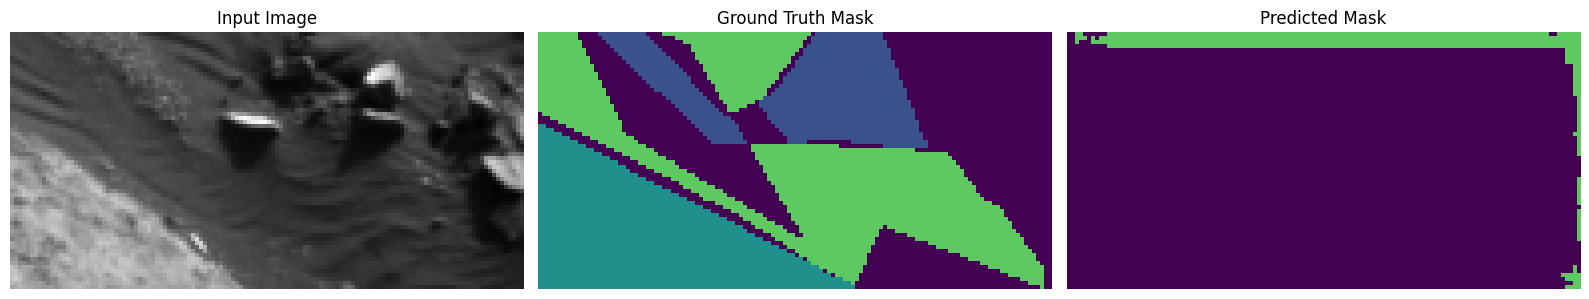

63/63 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - intermediate_output_accuracy: 0.3445 - intermediate_output_mean_iou: 0.1610 - loss: 2.5052 - output_layer_accuracy: 0.2782 - output_layer_mean_iou: 0.1480 - val_intermediate_output_accuracy: 0.1940 - val_intermediate_output_mean_iou: 0.0507 - val_loss: 2.1647 - val_output_layer_accuracy: 0.2407 - val_output_layer_mean_iou: 0.0580
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step - intermediate_output_accuracy: 0.5348 - intermediate_output_mean_iou: 0.2829 - loss: 1.1629 - output_layer_accuracy: 0.5442 - output_layer_mean_iou: 0.3015 - val_intermediate_output_accuracy: 0.1940 - val_intermediate_output_mean_iou: 0.0507 - val_loss: 2.7107 - val_output_layer_accuracy: 0.2003 - val_output_layer_mean_iou: 0.0431
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - intermediate_output_accuracy: 0.5902 - intermediate_output_mean_iou: 0.3229 - loss: 1.0365 - output_layer_accuracy: 0.6019 - output_layer_mean_iou: 0.3448 - val_intermediate_output

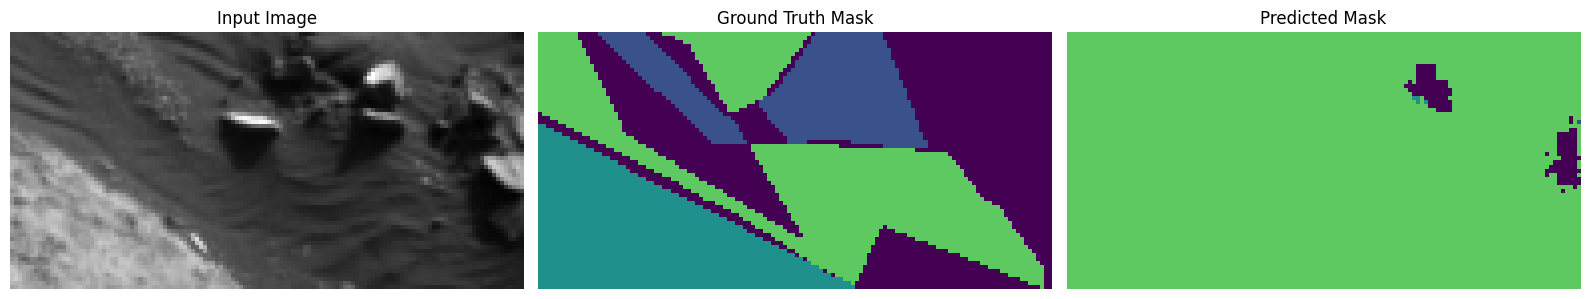

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - intermediate_output_accuracy: 0.6403 - intermediate_output_mean_iou: 0.3628 - loss: 0.9022 - output_layer_accuracy: 0.6516 - output_layer_mean_iou: 0.3843 - val_intermediate_output_accuracy: 0.2146 - val_intermediate_output_mean_iou: 0.0620 - val_loss: 2.4079 - val_output_layer_accuracy: 0.2289 - val_output_layer_mean_iou: 0.0618
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - intermediate_output_accuracy: 0.6557 - intermediate_output_mean_iou: 0.3748 - loss: 0.8668 - output_layer_accuracy: 0.6642 - output_layer_mean_iou: 0.3966 - val_intermediate_output_accuracy: 0.3143 - val_intermediate_output_mean_iou: 0.1299 - val_loss: 1.8405 - val_output_layer_accuracy: 0.3265 - val_output_layer_mean_iou: 0.1333
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - intermediate_output_accuracy: 0.6629 - intermediate_output_mean_iou: 0.3831 - loss: 0.8555 - output_layer_accuracy: 0.6718 - output_layer_mean_iou: 0.4031 - val_intermediate_outp

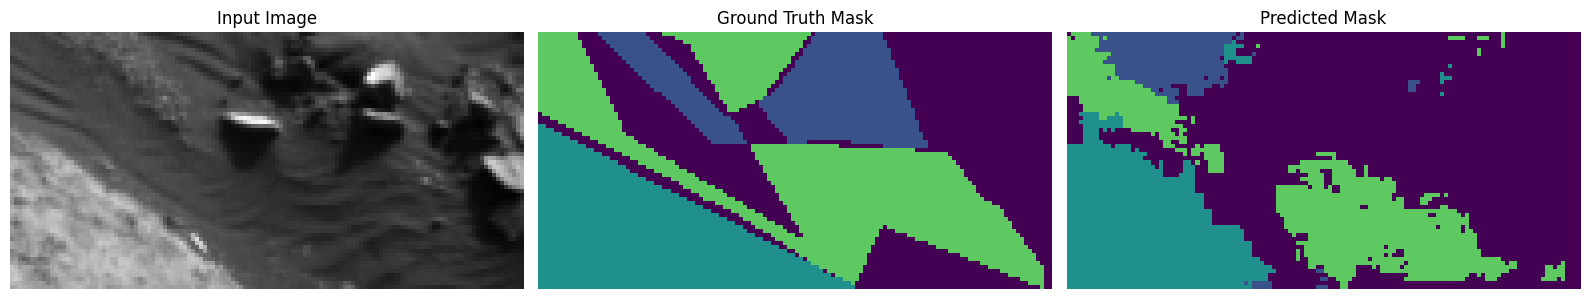

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - intermediate_output_accuracy: 0.6846 - intermediate_output_mean_iou: 0.3994 - loss: 0.8029 - output_layer_accuracy: 0.6927 - output_layer_mean_iou: 0.4203 - val_intermediate_output_accuracy: 0.6723 - val_intermediate_output_mean_iou: 0.3950 - val_loss: 0.8493 - val_output_layer_accuracy: 0.6848 - val_output_layer_mean_iou: 0.4079
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - intermediate_output_accuracy: 0.6851 - intermediate_output_mean_iou: 0.3987 - loss: 0.7985 - output_layer_accuracy: 0.6923 - output_layer_mean_iou: 0.4205 - val_intermediate_output_accuracy: 0.6771 - val_intermediate_output_mean_iou: 0.3926 - val_loss: 0.9085 - val_output_layer_accuracy: 0.6881 - val_output_layer_mean_iou: 0.4118
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - intermediate_output_accuracy: 0.6863 - intermediate_output_mean_iou: 0.3997 - loss: 0.7914 - output_layer_accuracy: 0.6937 - output_layer_mean_iou: 0.4206 - val_intermediate_ou

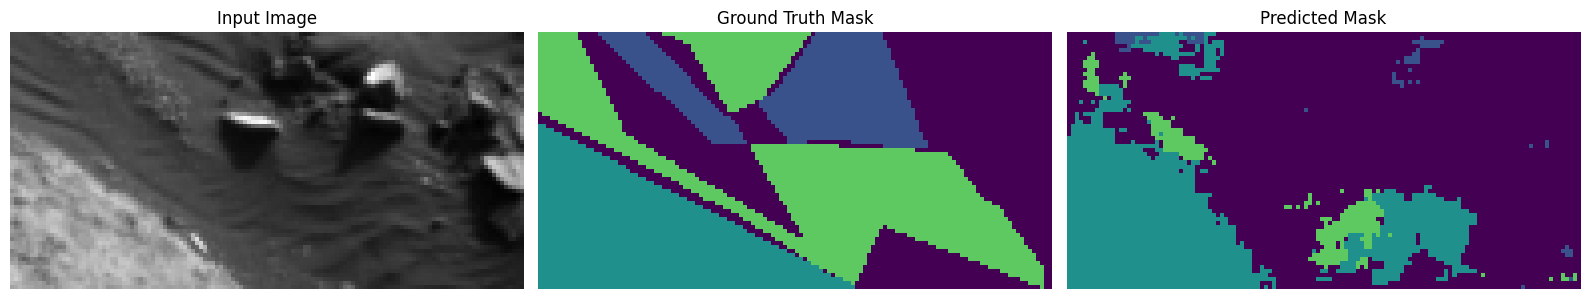

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - intermediate_output_accuracy: 0.6975 - intermediate_output_mean_iou: 0.4158 - loss: 0.7596 - output_layer_accuracy: 0.7066 - output_layer_mean_iou: 0.4342 - val_intermediate_output_accuracy: 0.6995 - val_intermediate_output_mean_iou: 0.4088 - val_loss: 0.7771 - val_output_layer_accuracy: 0.7109 - val_output_layer_mean_iou: 0.4347
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - intermediate_output_accuracy: 0.7064 - intermediate_output_mean_iou: 0.4201 - loss: 0.7476 - output_layer_accuracy: 0.7157 - output_layer_mean_iou: 0.4438 - val_intermediate_output_accuracy: 0.6859 - val_intermediate_output_mean_iou: 0.3968 - val_loss: 0.8255 - val_output_layer_accuracy: 0.6961 - val_output_layer_mean_iou: 0.4211
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - intermediate_output_accuracy: 0.7083 - intermediate_output_mean_iou: 0.4207 - loss: 0.7471 - output_layer_accuracy: 0.7171 - output_layer_mean_iou: 0.4473 - val_intermediate_ou

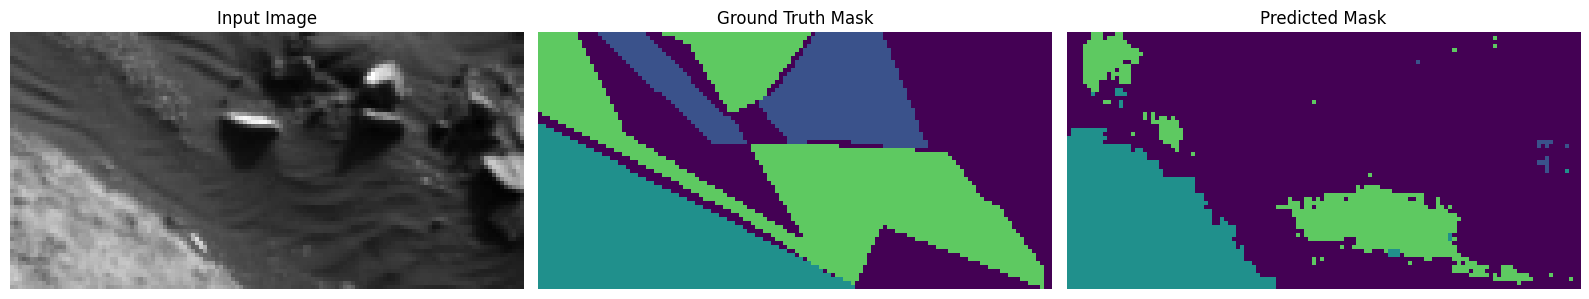

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - intermediate_output_accuracy: 0.7168 - intermediate_output_mean_iou: 0.4323 - loss: 0.7232 - output_layer_accuracy: 0.7247 - output_layer_mean_iou: 0.4540 - val_intermediate_output_accuracy: 0.7003 - val_intermediate_output_mean_iou: 0.4058 - val_loss: 0.7888 - val_output_layer_accuracy: 0.7083 - val_output_layer_mean_iou: 0.4345
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - intermediate_output_accuracy: 0.7167 - intermediate_output_mean_iou: 0.4317 - loss: 0.7243 - output_layer_accuracy: 0.7250 - output_layer_mean_iou: 0.4534 - val_intermediate_output_accuracy: 0.7080 - val_intermediate_output_mean_iou: 0.4136 - val_loss: 0.7572 - val_output_layer_accuracy: 0.7208 - val_output_layer_mean_iou: 0.4450
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - intermediate_output_accuracy: 0.7201 - intermediate_output_mean_iou: 0.4272 - loss: 0.7090 - output_layer_accuracy: 0.7298 - output_layer_mean_iou: 0.4566 - val_intermediate_ou

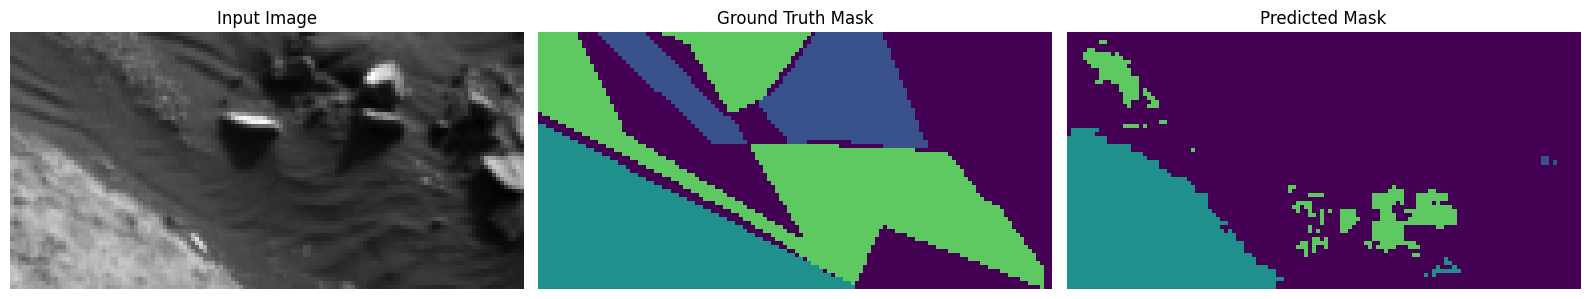

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - intermediate_output_accuracy: 0.7232 - intermediate_output_mean_iou: 0.4345 - loss: 0.6944 - output_layer_accuracy: 0.7326 - output_layer_mean_iou: 0.4596 - val_intermediate_output_accuracy: 0.7128 - val_intermediate_output_mean_iou: 0.4130 - val_loss: 0.7507 - val_output_layer_accuracy: 0.7247 - val_output_layer_mean_iou: 0.4523
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - intermediate_output_accuracy: 0.7320 - intermediate_output_mean_iou: 0.4395 - loss: 0.6819 - output_layer_accuracy: 0.7413 - output_layer_mean_iou: 0.4762 - val_intermediate_output_accuracy: 0.6988 - val_intermediate_output_mean_iou: 0.4004 - val_loss: 0.7944 - val_output_layer_accuracy: 0.7110 - val_output_layer_mean_iou: 0.4406
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - intermediate_output_accuracy: 0.7279 - intermediate_output_mean_iou: 0.4407 - loss: 0.6949 - output_layer_accuracy: 0.7363 - output_layer_mean_iou: 0.4694 - val_intermediate_ou

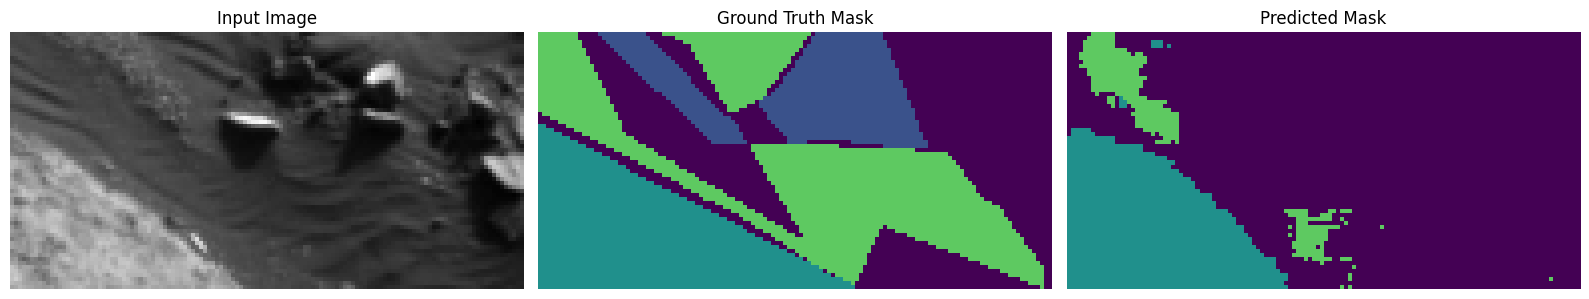

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - intermediate_output_accuracy: 0.7410 - intermediate_output_mean_iou: 0.4537 - loss: 0.6592 - output_layer_accuracy: 0.7501 - output_layer_mean_iou: 0.4788 - val_intermediate_output_accuracy: 0.7054 - val_intermediate_output_mean_iou: 0.4118 - val_loss: 0.7745 - val_output_layer_accuracy: 0.7144 - val_output_layer_mean_iou: 0.4441
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - intermediate_output_accuracy: 0.7389 - intermediate_output_mean_iou: 0.4446 - loss: 0.6679 - output_layer_accuracy: 0.7474 - output_layer_mean_iou: 0.4742 - val_intermediate_output_accuracy: 0.7302 - val_intermediate_output_mean_iou: 0.4385 - val_loss: 0.7254 - val_output_layer_accuracy: 0.7404 - val_output_layer_mean_iou: 0.4643
Epoch 33/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - intermediate_output_accuracy: 0.7458 - intermediate_output_mean_iou: 0.4520 - loss: 0.6480 - output_layer_accuracy: 0.7554 - output_layer_mean_iou: 0.4839 - val_intermediate_ou

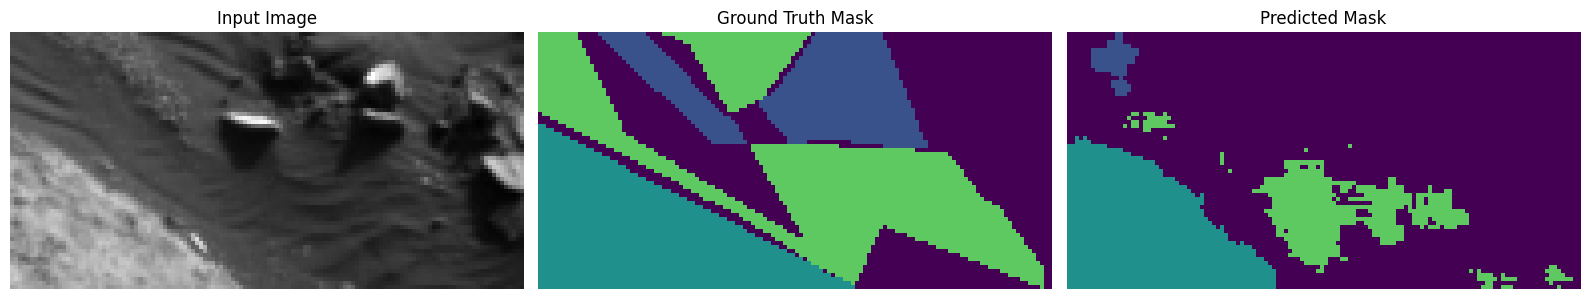

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - intermediate_output_accuracy: 0.7538 - intermediate_output_mean_iou: 0.4686 - loss: 0.6252 - output_layer_accuracy: 0.7630 - output_layer_mean_iou: 0.4996 - val_intermediate_output_accuracy: 0.7139 - val_intermediate_output_mean_iou: 0.4104 - val_loss: 0.7451 - val_output_layer_accuracy: 0.7245 - val_output_layer_mean_iou: 0.4497
Epoch 37/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - intermediate_output_accuracy: 0.7498 - intermediate_output_mean_iou: 0.4639 - loss: 0.6320 - output_layer_accuracy: 0.7599 - output_layer_mean_iou: 0.4919 - val_intermediate_output_accuracy: 0.7291 - val_intermediate_output_mean_iou: 0.4318 - val_loss: 0.7112 - val_output_layer_accuracy: 0.7391 - val_output_layer_mean_iou: 0.4633
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - intermediate_output_accuracy: 0.7532 - intermediate_output_mean_iou: 0.4670 - loss: 0.6230 - output_layer_accuracy: 0.7623 - output_layer_mean_iou: 0.4899 - val_intermediate_ou

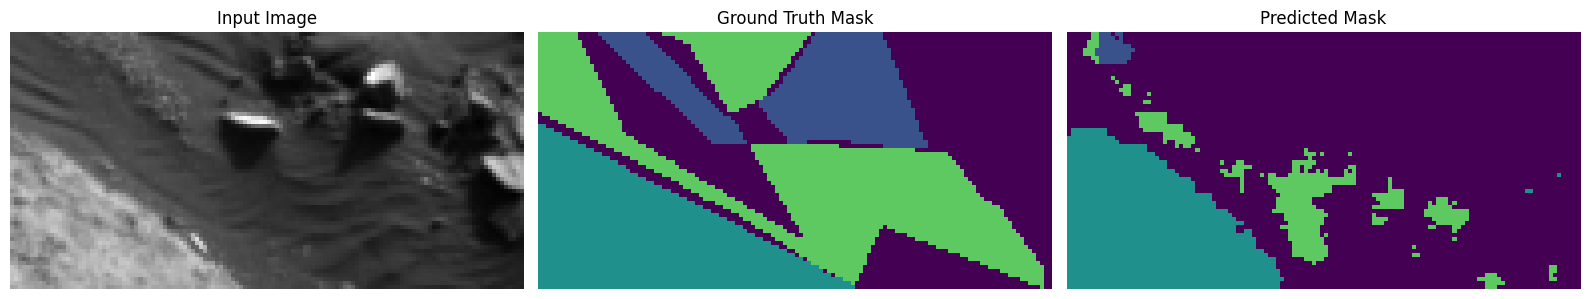

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - intermediate_output_accuracy: 0.7512 - intermediate_output_mean_iou: 0.4664 - loss: 0.6257 - output_layer_accuracy: 0.7608 - output_layer_mean_iou: 0.4899 - val_intermediate_output_accuracy: 0.7276 - val_intermediate_output_mean_iou: 0.4276 - val_loss: 0.6923 - val_output_layer_accuracy: 0.7401 - val_output_layer_mean_iou: 0.4658
Epoch 42/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - intermediate_output_accuracy: 0.7613 - intermediate_output_mean_iou: 0.4670 - loss: 0.6111 - output_layer_accuracy: 0.7712 - output_layer_mean_iou: 0.5083 - val_intermediate_output_accuracy: 0.7365 - val_intermediate_output_mean_iou: 0.4389 - val_loss: 0.6793 - val_output_layer_accuracy: 0.7467 - val_output_layer_mean_iou: 0.4730
Epoch 43/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - intermediate_output_accuracy: 0.7607 - intermediate_output_mean_iou: 0.4653 - loss: 0.5971 - output_layer_accuracy: 0.7703 - output_layer_mean_iou: 0.4989 - val_intermediate_ou

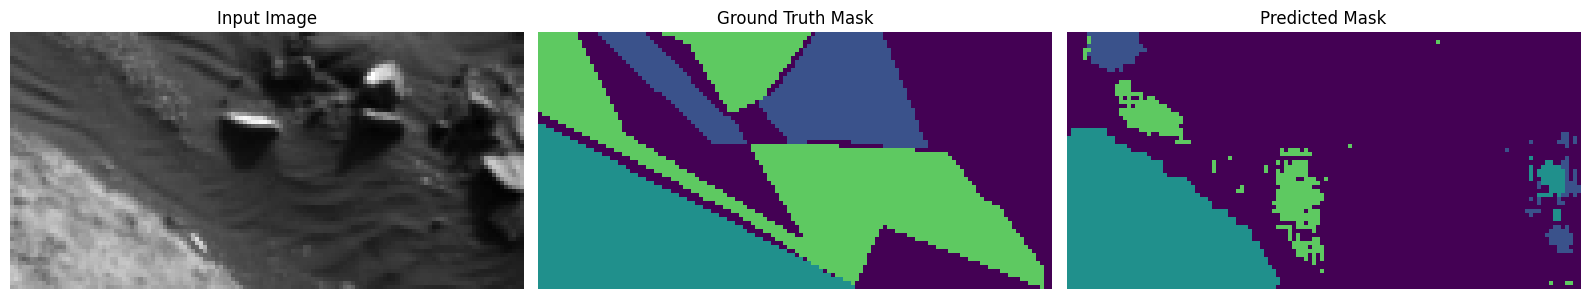

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - intermediate_output_accuracy: 0.7575 - intermediate_output_mean_iou: 0.4716 - loss: 0.6047 - output_layer_accuracy: 0.7661 - output_layer_mean_iou: 0.5071 - val_intermediate_output_accuracy: 0.7321 - val_intermediate_output_mean_iou: 0.4363 - val_loss: 0.7071 - val_output_layer_accuracy: 0.7432 - val_output_layer_mean_iou: 0.4663
Epoch 47/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - intermediate_output_accuracy: 0.7680 - intermediate_output_mean_iou: 0.4775 - loss: 0.5912 - output_layer_accuracy: 0.7776 - output_layer_mean_iou: 0.5162 - val_intermediate_output_accuracy: 0.7205 - val_intermediate_output_mean_iou: 0.4233 - val_loss: 0.7437 - val_output_layer_accuracy: 0.7306 - val_output_layer_mean_iou: 0.4570
Epoch 48/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - intermediate_output_accuracy: 0.7586 - intermediate_output_mean_iou: 0.4712 - loss: 0.6092 - output_layer_accuracy: 0.7685 - output_layer_mean_iou: 0.4975 - val_intermediate_ou

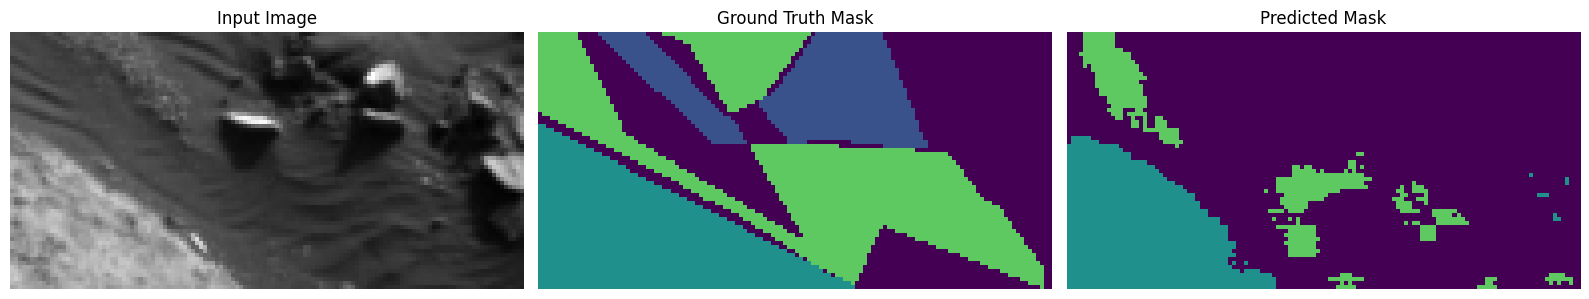

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - intermediate_output_accuracy: 0.7726 - intermediate_output_mean_iou: 0.4762 - loss: 0.5724 - output_layer_accuracy: 0.7822 - output_layer_mean_iou: 0.5120 - val_intermediate_output_accuracy: 0.7164 - val_intermediate_output_mean_iou: 0.4170 - val_loss: 0.7285 - val_output_layer_accuracy: 0.7281 - val_output_layer_mean_iou: 0.4589
Epoch 52/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - intermediate_output_accuracy: 0.7790 - intermediate_output_mean_iou: 0.4915 - loss: 0.5542 - output_layer_accuracy: 0.7881 - output_layer_mean_iou: 0.5260 - val_intermediate_output_accuracy: 0.7400 - val_intermediate_output_mean_iou: 0.4440 - val_loss: 0.6917 - val_output_layer_accuracy: 0.7522 - val_output_layer_mean_iou: 0.4768
Epoch 53/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - intermediate_output_accuracy: 0.7779 - intermediate_output_mean_iou: 0.4857 - loss: 0.5677 - output_layer_accuracy: 0.7873 - output_layer_mean_iou: 0.5178 - val_intermediate_ou

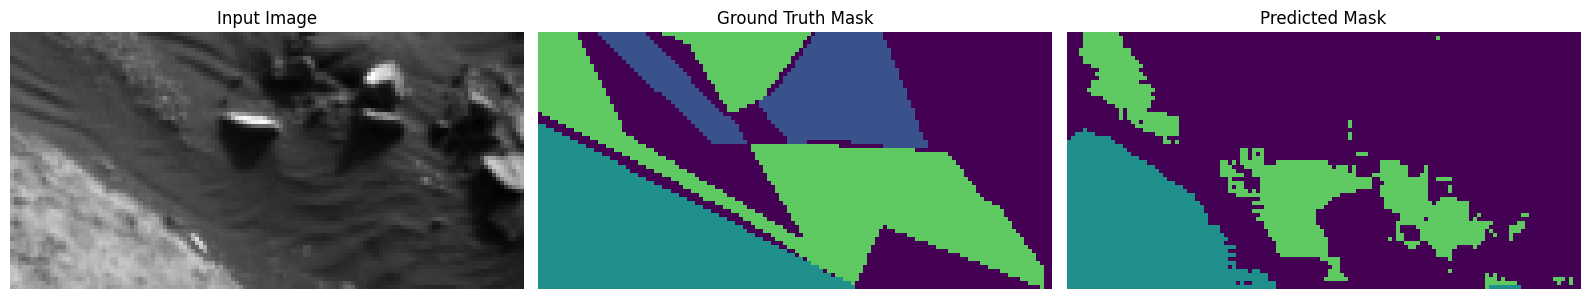

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - intermediate_output_accuracy: 0.7838 - intermediate_output_mean_iou: 0.4878 - loss: 0.5447 - output_layer_accuracy: 0.7936 - output_layer_mean_iou: 0.5246 - val_intermediate_output_accuracy: 0.7156 - val_intermediate_output_mean_iou: 0.4135 - val_loss: 0.7434 - val_output_layer_accuracy: 0.7278 - val_output_layer_mean_iou: 0.4580
Epoch 57/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - intermediate_output_accuracy: 0.7773 - intermediate_output_mean_iou: 0.4866 - loss: 0.5586 - output_layer_accuracy: 0.7879 - output_layer_mean_iou: 0.5190 - val_intermediate_output_accuracy: 0.7263 - val_intermediate_output_mean_iou: 0.4330 - val_loss: 0.7371 - val_output_layer_accuracy: 0.7373 - val_output_layer_mean_iou: 0.4597
Epoch 58/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - intermediate_output_accuracy: 0.7789 - intermediate_output_mean_iou: 0.4816 - loss: 0.5530 - output_layer_accuracy: 0.7896 - output_layer_mean_iou: 0.5225 - val_intermediate_ou

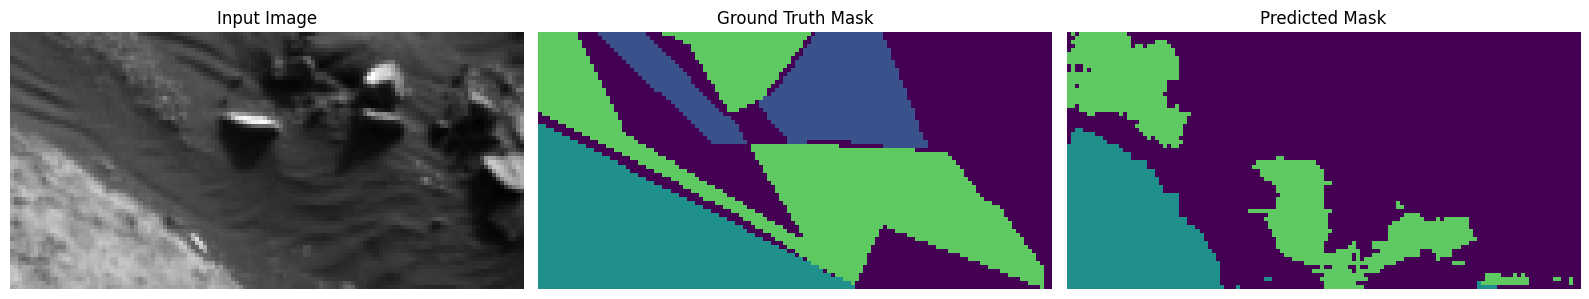

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - intermediate_output_accuracy: 0.7840 - intermediate_output_mean_iou: 0.4927 - loss: 0.5376 - output_layer_accuracy: 0.7941 - output_layer_mean_iou: 0.5264 - val_intermediate_output_accuracy: 0.6989 - val_intermediate_output_mean_iou: 0.3905 - val_loss: 0.8196 - val_output_layer_accuracy: 0.7119 - val_output_layer_mean_iou: 0.4371
Epoch 62/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - intermediate_output_accuracy: 0.7866 - intermediate_output_mean_iou: 0.4881 - loss: 0.5351 - output_layer_accuracy: 0.7963 - output_layer_mean_iou: 0.5286 - val_intermediate_output_accuracy: 0.6859 - val_intermediate_output_mean_iou: 0.3816 - val_loss: 0.8434 - val_output_layer_accuracy: 0.7021 - val_output_layer_mean_iou: 0.4326
Epoch 63/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - intermediate_output_accuracy: 0.7916 - intermediate_output_mean_iou: 0.4912 - loss: 0.5244 - output_layer_accuracy: 0.8011 - output_layer_mean_iou: 0.5355 - val_intermediate_ou

In [31]:
# Do a first pass with the hybrid loss
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_output_layer_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")   

In [32]:
# Now edit the model and run again
patience = 30
reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience / 2, factor=0.1, min_lr=learning_rate / 100
)

callbacks = [early_stopping, viz_callback, reduce_lr_callback]

def none_loss(y_true, y_pred):
    return 0.0

print("Recompiling model...")
model.compile(
    loss={"output_layer": iou_loss_no_zero, "intermediate_output": none_loss},
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics={
        "output_layer": ["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[], name="mean_iou")],  # Metrics for final output
        "intermediate_output": ["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0], name="mean_iou")],  # Metric for intermediate output
    }
)
print("Model compiled!")

Recompiling model...
Model compiled!


Epoch 1/1000


/home/francezco/Desktop/exams/AN2DL/Lab/an2dl_env/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
2024-12-07 01:40:20.691445: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_34', 48 bytes spill stores, 48 bytes spill loads



62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - intermediate_output_accuracy: 0.7597 - intermediate_output_mean_iou: 0.4774 - loss: 0.5259 - output_layer_accuracy: 0.7669 - output_layer_mean_iou: 0.5002

2024-12-07 01:42:20.731419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_34', 48 bytes spill stores, 48 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - intermediate_output_accuracy: 0.7597 - intermediate_output_mean_iou: 0.4772 - loss: 0.5257 - output_layer_accuracy: 0.7669 - output_layer_mean_iou: 0.5001   

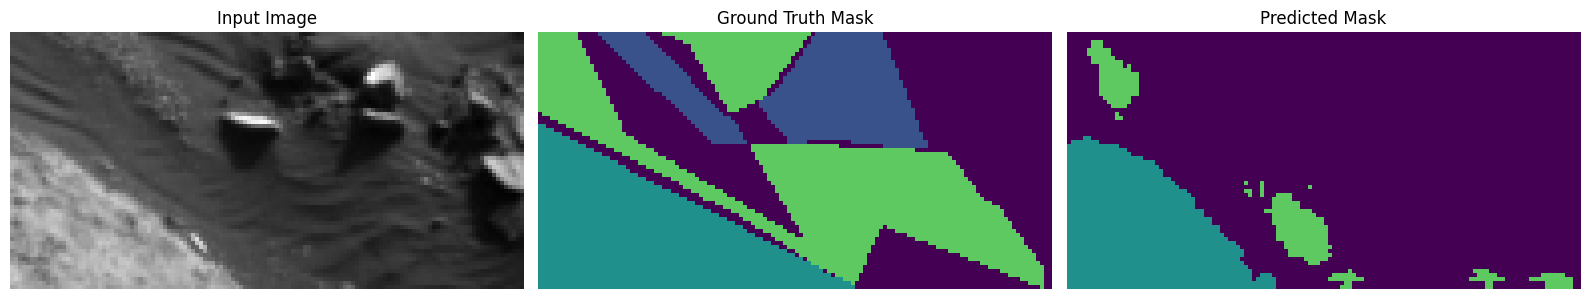

63/63 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - intermediate_output_accuracy: 0.7596 - intermediate_output_mean_iou: 0.4770 - loss: 0.5255 - output_layer_accuracy: 0.7668 - output_layer_mean_iou: 0.4999 - val_intermediate_output_accuracy: 0.6943 - val_intermediate_output_mean_iou: 0.3954 - val_loss: 0.5769 - val_output_layer_accuracy: 0.7157 - val_output_layer_mean_iou: 0.4426 - learning_rate: 1.0000e-04
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - intermediate_output_accuracy: 0.7499 - intermediate_output_mean_iou: 0.4550 - loss: 0.5155 - output_layer_accuracy: 0.7598 - output_layer_mean_iou: 0.4864 - val_intermediate_output_accuracy: 0.7326 - val_intermediate_output_mean_iou: 0.4393 - val_loss: 0.5202 - val_output_layer_accuracy: 0.7527 - val_output_layer_mean_iou: 0.4772 - learning_rate: 1.0000e-04
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - intermediate_output_accuracy: 0.7600 - intermediate_output_mean_iou: 0.4695 - loss: 0.4918 - output_layer_accuracy: 0.7712 -

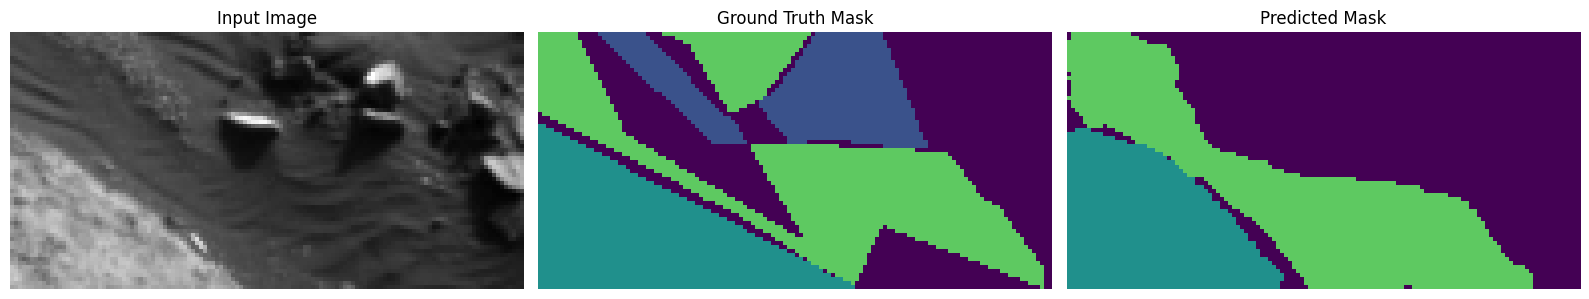

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - intermediate_output_accuracy: 0.7613 - intermediate_output_mean_iou: 0.4782 - loss: 0.4817 - output_layer_accuracy: 0.7686 - output_layer_mean_iou: 0.5042 - val_intermediate_output_accuracy: 0.7103 - val_intermediate_output_mean_iou: 0.4129 - val_loss: 0.5427 - val_output_layer_accuracy: 0.7197 - val_output_layer_mean_iou: 0.4501 - learning_rate: 1.0000e-04
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - intermediate_output_accuracy: 0.7543 - intermediate_output_mean_iou: 0.4655 - loss: 0.5019 - output_layer_accuracy: 0.7639 - output_layer_mean_iou: 0.4948 - val_intermediate_output_accuracy: 0.7159 - val_intermediate_output_mean_iou: 0.4312 - val_loss: 0.5231 - val_output_layer_accuracy: 0.7298 - val_output_layer_mean_iou: 0.4653 - learning_rate: 1.0000e-04
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - intermediate_output_accuracy: 0.7507 - intermediate_output_mean_iou: 0.4607 - loss: 0.4911 - output_layer_accuracy: 0.7604

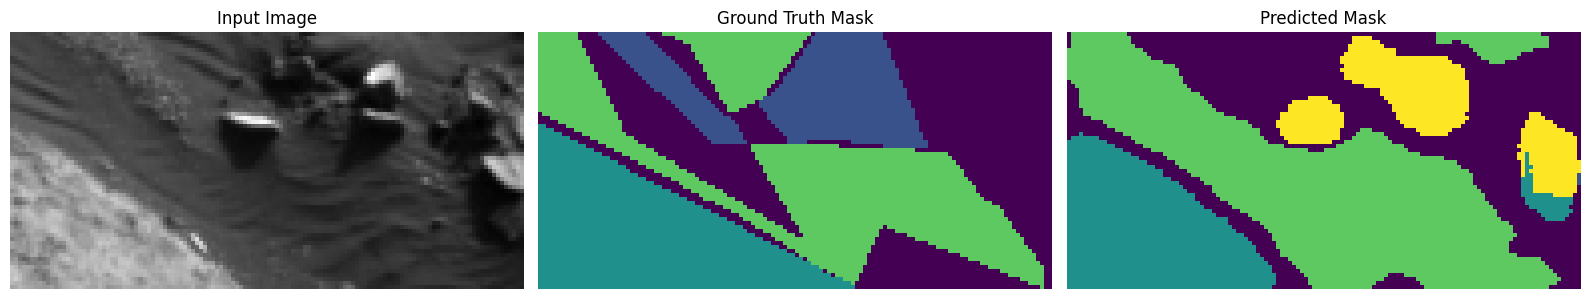

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - intermediate_output_accuracy: 0.7653 - intermediate_output_mean_iou: 0.4805 - loss: 0.4709 - output_layer_accuracy: 0.7795 - output_layer_mean_iou: 0.5194 - val_intermediate_output_accuracy: 0.7048 - val_intermediate_output_mean_iou: 0.4137 - val_loss: 0.5317 - val_output_layer_accuracy: 0.7170 - val_output_layer_mean_iou: 0.4490 - learning_rate: 1.0000e-04
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - intermediate_output_accuracy: 0.7642 - intermediate_output_mean_iou: 0.4833 - loss: 0.4749 - output_layer_accuracy: 0.7728 - output_layer_mean_iou: 0.5128 - val_intermediate_output_accuracy: 0.7233 - val_intermediate_output_mean_iou: 0.4340 - val_loss: 0.5244 - val_output_layer_accuracy: 0.7378 - val_output_layer_mean_iou: 0.4596 - learning_rate: 1.0000e-04
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - intermediate_output_accuracy: 0.7627 - intermediate_output_mean_iou: 0.4776 - loss: 0.4815 - output_layer_accuracy: 0.77

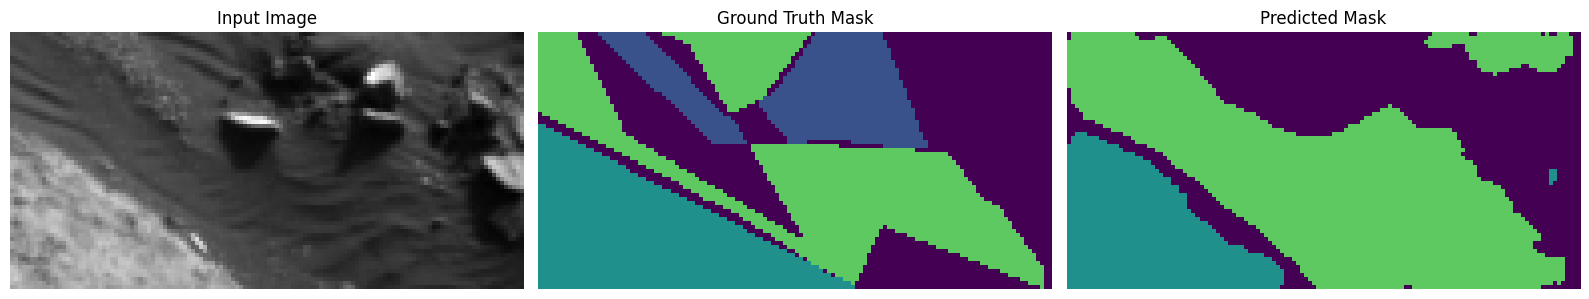

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - intermediate_output_accuracy: 0.7635 - intermediate_output_mean_iou: 0.4829 - loss: 0.4710 - output_layer_accuracy: 0.7780 - output_layer_mean_iou: 0.5215 - val_intermediate_output_accuracy: 0.7012 - val_intermediate_output_mean_iou: 0.4064 - val_loss: 0.5476 - val_output_layer_accuracy: 0.7227 - val_output_layer_mean_iou: 0.4443 - learning_rate: 1.0000e-04
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - intermediate_output_accuracy: 0.7611 - intermediate_output_mean_iou: 0.4733 - loss: 0.4784 - output_layer_accuracy: 0.7764 - output_layer_mean_iou: 0.5156 - val_intermediate_output_accuracy: 0.7344 - val_intermediate_output_mean_iou: 0.4615 - val_loss: 0.5011 - val_output_layer_accuracy: 0.7522 - val_output_layer_mean_iou: 0.4786 - learning_rate: 1.0000e-04
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - intermediate_output_accuracy: 0.7674 - intermediate_output_mean_iou: 0.4862 - loss: 0.4670 - output_layer_accuracy: 0.78

In [33]:
# Do the final pass with the final loss
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_output_layer_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")   

In [34]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241207_015021.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [35]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241207_015021.keras


In [36]:
preds = model.predict(X_test)[0]
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 49s 115ms/step


2024-12-07 01:51:24.498067: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 821002240 exceeds 10% of free system memory.


Predictions shape: (10022, 64, 128)


In [37]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [38]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# from google.colab import files
# files.download(submission_filename)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step
Accuracy score over the test set: 0.7429
Precision score over the test set: 0.7418
Recall score over the test set: 0.7429
F1 score over the test set: 0.7418


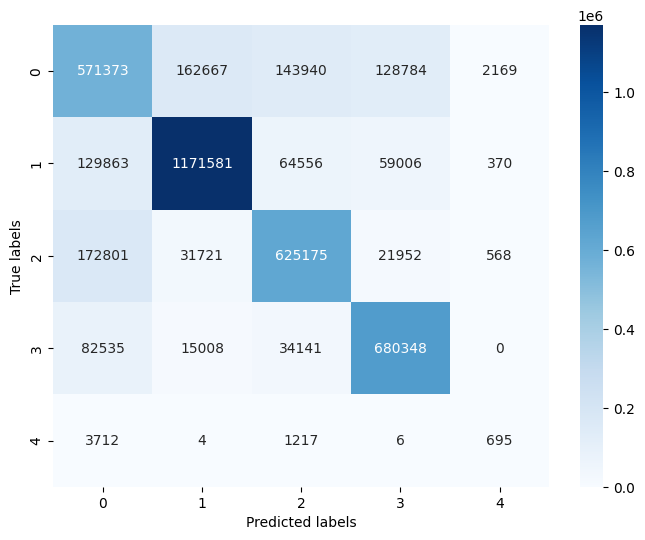

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Predict class probabilities and get predicted classes on the validation set.
test_predictions = np.argmax(model.predict(X_val)[0], axis=-1).flatten()

# Extract ground truth classes.
test_gt = y_val.flatten()

# Calculate and display test set accuracy.
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision.
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall.
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score.
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix.
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values.
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(num_classes), yticklabels=range(num_classes), cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```